In [54]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


In [55]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

# レスラー方程式の定義
def rossler_system(t, state, a, b, c):
    x, y, z = state
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

# パラメータ
a = 0.2
b = 0.2
c = 5.7

# 初期条件
initial_state = [1.0, 1.0, 1.0]

# 時間の設定
t_span = [0, 2510]  # 開始時刻と終了時刻
t_eval = np.linspace(t_span[0], t_span[1], 25100)  # 評価する時間点

# 微分方程式の数値解を求める
solution = solve_ivp(rossler_system, t_span, initial_state, args=(a, b, c), t_eval=t_eval, max_step=0.01)

# CSVファイルにデータを保存するためのDataFrameを作成
data_frame = pd.DataFrame({
    'time': solution.t,
    'x': solution.y[0],
    'y': solution.y[1],
    'z': solution.y[2]
})

# CSVファイルにデータを保存
filename = 'rossler_data1.2.1.csv'
data_frame.to_csv(filename, index=False)

# CSVファイルを読み込む
data_loaded = pd.read_csv(filename)

# CSVから値を抽出してNumpy配列に格納
X = data_loaded[['x', 'y']].values

print(X)


[[ 1.          1.        ]
 [ 0.81385718  1.11163049]
 [ 0.64680298  1.20777255]
 ...
 [-7.69976375  3.78643257]
 [-8.04437468  3.06721505]
 [-8.31468333  2.30236019]]


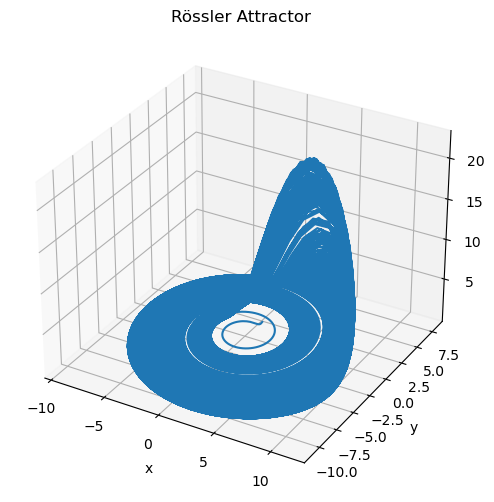

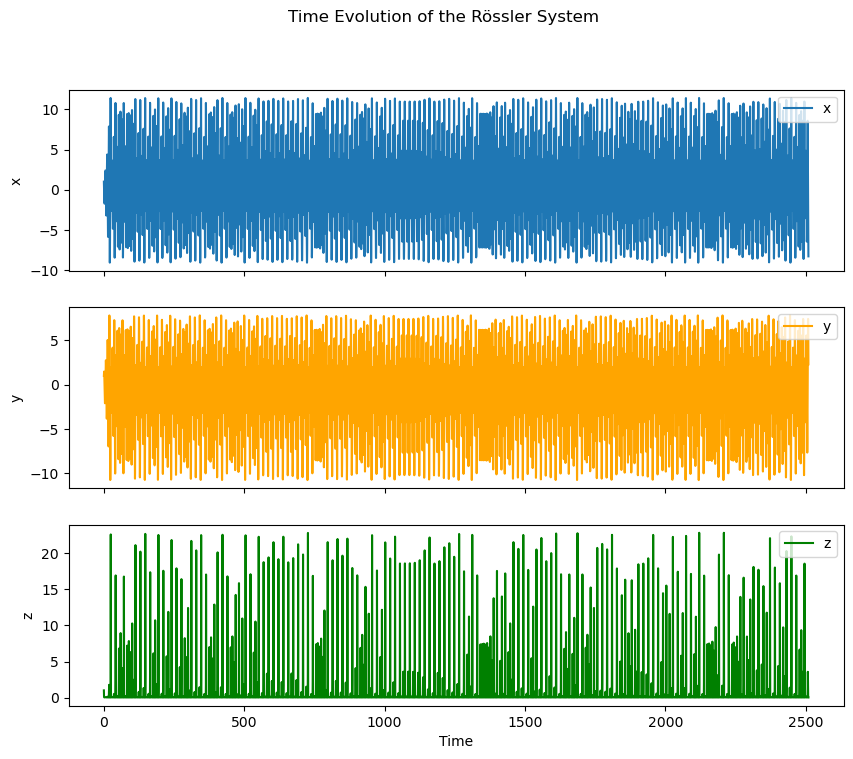

In [56]:
# XYZの三次元グラフをプロット
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data_frame['x'], data_frame['y'], data_frame['z'])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Rössler Attractor')
plt.show()

# 時間ごとのx, y, zそれぞれのグラフ
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axs[0].plot(data_frame['time'], data_frame['x'], label='x')
axs[0].set_ylabel('x')
axs[0].legend(loc='upper right')

axs[1].plot(data_frame['time'], data_frame['y'], label='y', color='orange')
axs[1].set_ylabel('y')
axs[1].legend(loc='upper right')

axs[2].plot(data_frame['time'], data_frame['z'], label='z', color='green')
axs[2].set_ylabel('z')
axs[2].set_xlabel('Time')
axs[2].legend(loc='upper right')

plt.suptitle('Time Evolution of the Rössler System')
plt.show()


ここまで，正しくシミュレーションが出来た．

実際にESNを用いる際に扱うデータはXであるが，これはレスラー方程式のx, y項のみを含む二次元の配列である．

In [57]:
X.shape

(25100, 2)

### 2. hyperoptを用いたESNのパラメータの最適化

ESNを用いる際に決定しなければならないhyperparameterの初期値をhyperoptを用いて最適化する．

注．quniformの使い方に慣れていないが，ここでは自分で整数に丸めて使うことにする．

In [58]:
from hyperopt import hp, tpe, Trials, fmin

In [59]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        prediction = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test, prediction, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, prediction)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [60]:
hyperopt_config = {
    "exp": f"hyperopt-rossler1.2.1", # the experimentation name
    "hp_max_evals": 300,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 5555]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)


In [61]:
from reservoirpy.datasets import to_forecasting

train_len = 10000
test_len = 10000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+test_len], y[train_len:train_len+test_len]

dataset = ((X_train, y_train), (X_test, y_test))

In [62]:
from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 300/300 [23:36<00:00,  4.72s/trial, best loss: 5.0812787946098806e-06]


In [63]:
# `best`タプルの最初の要素には最適化されたハイパーパラメータが直接含まれています
best_params = best[0]

# numpy int64型をPythonのint型に変換するための関数
def convert(o):
    if isinstance(o, np.int64): return int(o)
    raise TypeError

# 最適なハイパーパラメータをJSONファイルに保存
with open(f"{hyperopt_config['exp']}_best_params.json", 'w') as f:
    json.dump(best_params, f, default=convert)

In [65]:
best

({'N': 0,
  'iss': 0.0847552772285739,
  'lr': 0.4589596869564032,
  'ridge': 4.843985123099407e-09,
  'seed': 0,
  'sr': 0.8361142665850508},
 <hyperopt.base.Trials at 0x168edda30>)

最適化が完了したので，このパラメータを用いて未来予測を行ってみる．

### 1.0 終わり

追記．train_lenを10000にしたところ，違うパラメータを得られた．学習が完了していなかったのかもしれない．